# Imports

In [1]:
%pylab inline
import pandas as pd
import seaborn as sns
import matplotlib.gridspec as gridspec

from scipy.spatial.distance import euclidean
from scipy.spatial import distance_matrix
from scipy.stats import binom_test 
import scipy.stats

import collections
from itertools import combinations
import string

%load_ext autoreload
%autoreload 2

warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

import Co_Evo_Func as cef

sns.set_style('white')
sns.set_context('poster')
plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams["font.family"] = "calibri"

Populating the interactive namespace from numpy and matplotlib


# Analysis

## Preproccessing

In [2]:
counts = pd.read_excel("raw_data/counts_uni.xlsx", index_col=0)

doc_rep = counts[(counts['sample_kind'].isin(['Monoculture', 'Pair', 'Trio']))&(counts['transfer']==0)].groupby('sample')['sample_kind'].count() #for documentation 
counts['Generation'] = counts['transfer']*10.5  # translate transfers to generations
species = counts.loc[:, 'Ea':'IN72'].columns # list of species in the experiment
counts['total'] = counts[species].sum(axis = 1) # total counts for each row
counts = counts[counts['total']>0] # Remove rows with no counts
counts['present'] = counts[species].apply(lambda x:x>0, axis = 1).apply(lambda x: list(species[x.values]), axis=1) # which species are present at each count
counts = counts[counts['sample_kind'].isin(['Pair', 'Trio'])].reset_index(drop = True) # leave only pairs and trios
counts = counts[~counts['transfer'].isin([13, 15])].reset_index(drop = True) # Two transfers were we sampled only a small number of communities


Samples that did not coexist for at least 70 generations are taken out of the analysis

In [3]:
coexistence = lambda x : True if all([sp in x['present'] for sp in x['sample'].split('_')]) else False
counts['coexistence'] = counts.apply(coexistence, axis = 1) # are all species that should be present present?
excluded = lambda x:[sp for sp in x['sample'].split('_') if sp not in x['present']][0] if len([sp for sp in x['sample'].split('_') if sp not in x['present']]) > 0 else 'non'
counts['excluded'] = counts.apply(excluded, axis =1) # Which species isn't present?

last_coex = lambda x: max(x['transfer'][x['coexistence']]) 
lc = counts.groupby(['sample_kind','sample','ident'])[['transfer', 'coexistence']].apply(last_coex) # what is the last timepoint that all species were present?
lc = pd.DataFrame(lc).reset_index()
lc = lc.rename(columns={0: 'last_coex'})
lc['excluded'] = lc.apply(lambda x:counts['excluded'][counts['ident']==x['ident']][counts['transfer']==38].values, axis = 1)


counts = counts[~counts['ident'].isin(lc['ident'][lc['last_coex']<7])].reset_index(drop = True) # remove ecologically non-coexsiting communities
counts = counts[counts['sample']!='Pa_Fj'].reset_index(drop = True) # Only in one well, at one time point a single colony of Fj apeared after generation ~70

Remove contaminated samples from the analysis

In [4]:
spot_contaminations = lambda x : False if all([sp in x['sample'].split('_') for sp in x['present']]) else True
counts['cont'] = counts.apply(spot_contaminations, axis = 1) # when a species which souldn't be present is present, set cont as True
first_cont = lambda x: min(x['transfer'][x['cont']].values) if (len(x['transfer'][x['cont']]) != 0) else 38 
fcont = counts[counts['sample_kind'].isin(['Pair', 'Trio'])].groupby(['ident'])[['transfer', 'cont']].apply(first_cont) # If cont == True where did it apear first
fcont = pd.DataFrame(fcont).reset_index()
for t, ide in zip(fcont[fcont[0]!=38][0], fcont[fcont[0]!=38]['ident']):
    # all datapoints after contamination appeared are considered contaminated
    counts['cont'][counts['ident']==ide][counts['transfer'] > t] = True
    
contaminated = counts['ident'][counts['cont']].unique()  # Documenting which replicates were taken out
contaminated_bysamp = counts[(counts['transfer']==38)&(counts['cont'])].groupby('sample').count()['sample_kind']
counts = counts[~counts['cont']].reset_index(drop = True)

In most of our analysis we use the fraction of the different species rather than the absolute numbers. 

In [5]:
 #### cf is noramlized version of counts ####
cf = counts.copy() 
cf[species] = cf[species].apply(lambda x:x/cf['total'])

#### cf_psu is noramlized version of counts with added pseudocounts ####
cf_psu = counts.copy() 
cf_psu = cf_psu.apply(cef.add_pseudocounts, axis = 1)
cf_psu['total'] = cf_psu[species].sum(axis = 1)

cf_psu[species] = cf_psu[species].apply(lambda x:x/cf_psu['total'])

cf['Gen_jit'] = cf['Generation']+ random.normal(0, 2, len(cf)) #jittered generation for some plots
cf.loc[cf['transfer']==0, 'Gen_jit'] = 0 #don't jitter t0

We define the change in community composition as the Euclidean distance between the composition of a replicate at two subsequent time points normalized to the maximal distance between two communities composed of the same n species

$$\frac{\sqrt{(f_{1_{t}}-f_{1_{t-1}})^2 + (f_{2_{t}}-f_{2_{t-1}})^2... + (f_{n_{t}}-f_{n_{t-1}})^2}}{\sqrt{n}}$$

In [6]:
### We define change as the Euclidean distance between a sample at two timepoints, normalized to the maximum possible change
cf['change'] = cf.groupby('ident')[species].apply(cef.euc_change)# quantify the distance of each timepoint from the last one
cf['change'] = cf.apply(lambda x:x['change']/sqrt(len(x['sample'].split('_'))), axis = 1) # the maximum possible change = sqrt(n)

### dist from ee is the change since generation 70
cf['dist_from_ee'] = cf.apply(lambda x: euclidean(x[species], cf.loc[(cf['transfer']==7)&(cf['ident'] == x['ident']), species]) if len(cf.loc[(cf['transfer']==7)&(cf['ident'] == x['ident']), species])!= 0 else NaN, axis = 1)
cf['dist_from_ee'] = cf.apply(lambda x:x['dist_from_ee']/sqrt(len(x['sample'].split('_'))), axis = 1)

In [7]:
pairs = cf['sample'][cf['sample_kind']=='Pair'].unique() # a list of pairs in the experiment
trios = cf['sample'][cf['sample_kind']=='Trio'].unique() # a list of trios in the experiment
species = cf.loc[:, 'Ea':'IN72'].columns # list of species in the experiment
transfers = cf['transfer'].unique()
gens = cf['Generation'].unique()
idents = cf['ident'].unique()

### 2A

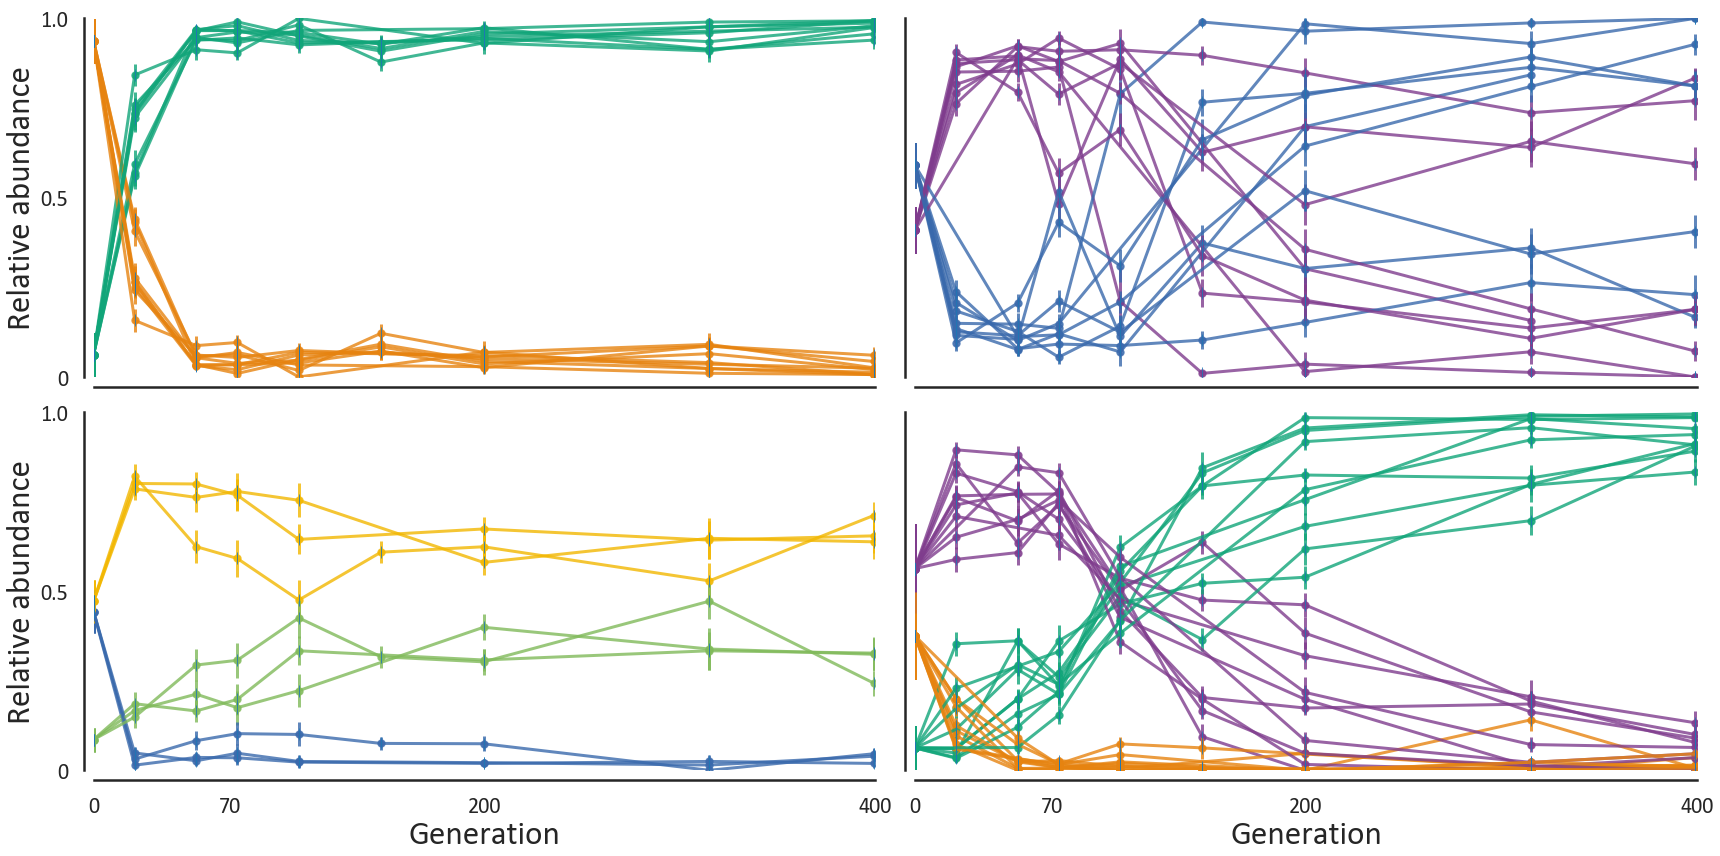

In [8]:
fig = plt.figure(constrained_layout=True, figsize=(24, 12))

costume_colors = ['#7F3C8D','#11A579','#3969AC','#F2B701',
                  '#E68310','#80BA5A','#E73F74','#008695',
                  '#CF1C90','#f97b72','#4b4b8f','#A5AA99',
                  '#252525', '#005a32','#c6dbef','#F01C00']

lf = {'fontsize':33}
tf = {'fontsize':25}


species = cf.loc[:, 'Ea':'IN72'].columns
color_map = dict(zip(species,costume_colors))

gs = gridspec.GridSpec(2, 4)
ax1 = fig.add_subplot(gs[0, 0:2])
ax2 = fig.add_subplot(gs[0, 2:4])
ax3 = fig.add_subplot(gs[1, 0:2])
ax4 = fig.add_subplot(gs[1, 2:4])
# plot Pa_Pv trajectory
cef.plot_trajectory(community='Pa_Pv', ax=ax1,cf=cf, cm=color_map,ticksfont=tf, labelfont=lf, alpha = 0.8)
ax1.set_xlabel('')
ax1.set_xticklabels([])
# plot Ea_Pch trajectory
cef.plot_trajectory(community='Ea_Pch', ax=ax2,cf=cf, cm=color_map,ticksfont=tf, labelfont=lf, alpha = 0.8)
ax2.set_xlabel('')
ax2.set_xticklabels([])
ax2.set_ylabel('')
ax2.set_yticklabels([])
# plot Pch_Pci_Pf trajectory
cef.plot_trajectory(community='Pch_Pci_Pf', ax=ax3,cf=cf, cm=color_map,ticksfont=tf, labelfont=lf, xtick=[0, 70, 200, 400], alpha = 0.8)
# plot Ea_Pa_Pv trajectory
cef.plot_trajectory(community='Ea_Pa_Pv', ax=ax4,cf=cf, cm=color_map,ticksfont=tf, labelfont=lf, xtick=[0, 70, 200, 400], alpha = 0.8)
ax4.set_ylabel('')
ax4.set_yticklabels([])




sns.despine(offset=10)
tight_layout()


### 2B, C

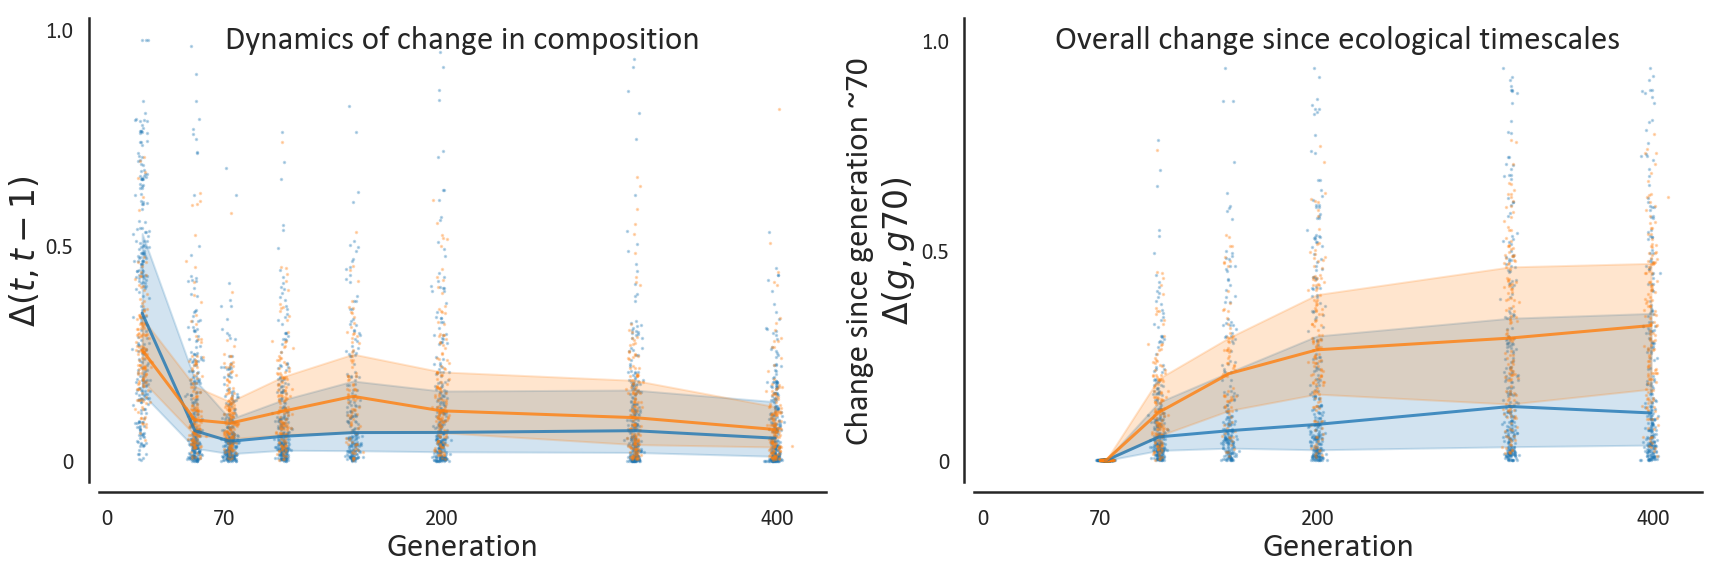

In [9]:
fig, (ax1, ax2) = subplots(1, 2, figsize=(24, 8), sharex=True)

gens = cf['Generation'].unique()
#______________________________________________Dynamics of change___________________________________________________#

# plot pairs
ax1.scatter(cf['Gen_jit'][cf['sample_kind']=='Pair'], cf['change'][cf['sample_kind']=='Pair'], s = 2, alpha =0.3)
ax1.plot(cf[cf['sample_kind']=='Pair'].groupby('Generation').median(skipna = True)['change'], alpha = 0.8)

ax1.fill_between(gens, 
                 cf[cf['sample_kind']=='Pair'].groupby('Generation').quantile(0.75)['change'],
                 cf[cf['sample_kind']=='Pair'].groupby('Generation').quantile(0.25)['change'], 
                color = sns.color_palette()[0], alpha = 0.2)
# plot trios
ax1.scatter(cf['Gen_jit'][cf['sample_kind']=='Trio'], cf['change'][cf['sample_kind']=='Trio'], s = 2, alpha =0.3)
ax1.plot(cf[cf['sample_kind']=='Trio'].groupby('Generation').median(skipna = True)['change'], alpha = 0.8)

ax1.fill_between(gens, 
                 cf[cf['sample_kind']=='Trio'].groupby('Generation').quantile(0.75)['change'],
                 cf[cf['sample_kind']=='Trio'].groupby('Generation').quantile(0.25)['change'], 
                color = sns.color_palette()[1], alpha = 0.2)

ax1.set_yticks([0, 0.5, 1.])
ax1.set_yticklabels([0, 0.5, 1.], fontdict=lf)
ax1.set_xticks([0, 200, 400])
ax1.set_xticklabels([0, 200, 400], fontdict=lf)
ax1.set_ylabel('$\Delta (t, t-1)$', fontdict=lf)
ax1.set_xlabel('Generation', fontdict=lf)
ax1.set_title('Dynamics of change in composition', fontdict=lf, pad = -30)

#______________________________________________Change since eco timescales __________________________________________#

#plot pairs
ax2.scatter(cf[cf['sample_kind']=='Pair'][cf['transfer']>6]['Gen_jit'], cf[cf['sample_kind']=='Pair'][cf['transfer']>6]['dist_from_ee'], s = 2, alpha =0.3)
ax2.plot(cf[cf['sample_kind']=='Pair'][cf['transfer']>6].groupby('Generation').median(skipna = True)['dist_from_ee'], alpha = 0.8)
ax2.fill_between(gens[gens>60], 
                 cf[cf['sample_kind']=='Pair'][cf['transfer']>6].groupby('Generation').quantile(0.75)['dist_from_ee'],
                 cf[cf['sample_kind']=='Pair'][cf['transfer']>6].groupby('Generation').quantile(0.25)['dist_from_ee'], 
                color = sns.color_palette()[0], alpha = 0.2)

#plot trios
ax2.scatter(cf[cf['sample_kind']=='Trio'][cf['transfer']>6]['Gen_jit'], cf[cf['sample_kind']=='Trio'][cf['transfer']>6]['dist_from_ee'], s = 2, alpha =0.3)
ax2.plot(cf[cf['sample_kind']=='Trio'][cf['transfer']>6].groupby('Generation').median(skipna = True)['dist_from_ee'], alpha = 0.8)
ax2.fill_between(gens[gens>60], 
                 cf[cf['sample_kind']=='Trio'][cf['transfer']>6].groupby('Generation').quantile(0.75)['dist_from_ee'],
                 cf[cf['sample_kind']=='Trio'][cf['transfer']>6].groupby('Generation').quantile(0.25)['dist_from_ee'], 
                color = sns.color_palette()[1], alpha = 0.2)


ax2.set_yticks([0, 0.5, 1.])
ax2.set_yticklabels([0, 0.5, 1.], fontdict=lf)
ax2.set_xticks([0, 70,200, 400])
ax2.set_xticklabels([0, 70,200, 400], fontdict=lf)
ax2.set_ylabel('Change since generation ~70\n$\Delta (g, g70)$', fontdict=lf)
ax2.set_xlabel('Generation', fontdict=lf)
ax2.set_title('Overall change since ecological timescales', fontdict=lf, pad = -30)


sns.despine(offset=10)
tight_layout()

In [10]:
OD = pd.read_excel("proccesed_data/OD_proccesed.xlsx") # OD table

### frac_od gives the abundances as fractional od (od X fraction)
frac_od = pd.merge(cf, OD[['ident', 'transfer', 'OD', 'smoothed']], on=['ident', 'transfer'])
frac_od[species] = frac_od[species].apply(lambda x:x*frac_od['smoothed'])


## Aggregated tables

In [11]:
#### group cf by sample for each t, avrage across replicates: ###
bysamp = cf.groupby(['sample', 'transfer', 'sample_kind', 'Generation'], as_index=False).mean() 
bysamp = bysamp.drop('cont', axis = 1) # drop some irelevent coloumns
bysamp['size'] = cf.groupby(['sample', 'transfer'], as_index=False).aggregate(np.size)['sample_kind'] 
# calculate the avarage distance from mediod for each
bysamp['dist_from_med'] = cf.groupby(['sample', 'transfer', 'sample_kind', 'Generation'])[species].apply(cef.dist_from_med).values 
bysamp['dist_from_med'] = bysamp.apply(lambda x:x['dist_from_med']/sqrt(len(x['sample'].split('_'))), axis = 1)

### by_ide is aggregated for each replicate across time
by_ide = cf.groupby(by = ['sample', 'ident', 'sample_kind'], as_index=False).mean()[['sample', 'ident', 'sample_kind']]
by_ide['change'] = cf.groupby('ident', as_index=False)['dist_from_ee'].apply(lambda x:x[x.index[len(x)-1]])

sum_data = by_ide.groupby(['sample','sample_kind'], as_index=False).mean()
sum_data['beta_div'] = bysamp[bysamp['transfer']==38].merge(sum_data, on = 'sample')['dist_from_med']
sum_data['beta_div_norm'] = log(sum_data['beta_div']/bysamp[bysamp['transfer']==7].merge(sum_data, on = 'sample')['dist_from_med'])

# bysamp.to_excel('proccesed_data/by_samp.xlsx')
# by_ide.to_excel('proccesed_data/by_ide.xlsx')
# sum_data.to_excel('proccesed_data/sum_data.xlsx')

## Repeatability

We measure the variability between replicate communities as the avarage distance from medoid. We compare these to the null model that species fractions are derived from a uniform distribution. 

In [12]:
### produce a random version of cf, where species fractions are derived from uniform distribution.
rand_cf = cf.apply(lambda x: cef.randomize_counts(x), axis = 1)
rand_grouped = rand_cf.groupby(['sample', 'Generation'])[species].apply(cef.dist_from_med).reset_index()
rand_grouped['var'] = rand_grouped.apply(lambda x:x[0]/sqrt(len(x['sample'].split('_'))), axis = 1)

### test the significance with Mann-Whitney u-test
from scipy.stats import mannwhitneyu

like_rand = pd.DataFrame(columns=['Generation', 'U', 'P'])
like_rand['Generation'] = cf['Generation'].unique()

like_rand['U'] = like_rand['Generation'].apply(lambda x:mannwhitneyu(bysamp[bysamp['Generation']==x]['dist_from_med'].values,
                                                                     rand_grouped.reset_index()[rand_grouped.reset_index()['Generation']==x][0].values,
                                                                      alternative = 'less')[0])
like_rand['P'] = like_rand['Generation'].apply(lambda x:mannwhitneyu(bysamp[bysamp['Generation']==x]['dist_from_med'].values,
                                                                     rand_grouped.reset_index()[rand_grouped.reset_index()['Generation']==x][0].values,
                                                                       alternative = 'less')[1])
like_rand

,Generation,U,P
0,0.0,170.0,2.817583e-31
1,21.0,481.0,1.370148e-23
2,52.5,393.0,9.263720e-25
3,73.5,415.0,1.828753e-24
4,105.0,660.0,2.653128e-21
5,147.0,1233.0,9.670479e-12
6,199.5,757.0,4.082314e-20
7,315.0,884.0,1.287848e-18
8,399.0,870.0,8.865793e-19


### Fig 3A

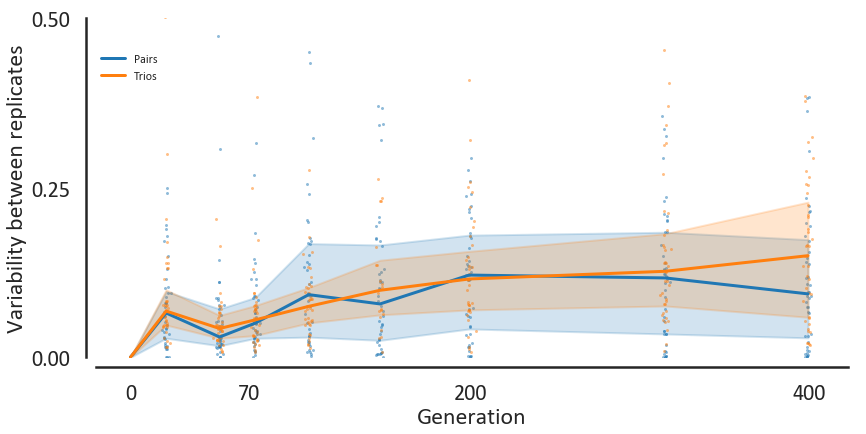

In [13]:
fig, ax1 = plt.subplots(1, 1, figsize = (12, 6))

ax1.scatter(bysamp['Gen_jit'][bysamp['sample_kind']=='Pair'], bysamp['dist_from_med'][bysamp['sample_kind']=='Pair'], s = 1, alpha=0.5)
ax1.plot(bysamp[bysamp['sample_kind']=='Pair'].groupby('Generation')['dist_from_med'].median())
ax1.fill_between(gens, 
                bysamp[bysamp['sample_kind']=='Pair'].groupby('Generation')['dist_from_med'].quantile(0.25),
                bysamp[bysamp['sample_kind']=='Pair'].groupby('Generation')['dist_from_med'].quantile(0.75),
                color = sns.color_palette()[0], alpha = 0.2)

ax1.scatter(bysamp['Gen_jit'][bysamp['sample_kind']=='Trio'], bysamp['dist_from_med'][bysamp['sample_kind']=='Trio'], s = 1, alpha=0.5)
ax1.plot(bysamp[bysamp['sample_kind']=='Trio'].groupby('Generation')['dist_from_med'].median())
ax1.fill_between(gens, 
                bysamp[bysamp['sample_kind']=='Trio'].groupby('Generation')['dist_from_med'].quantile(0.25),
                bysamp[bysamp['sample_kind']=='Trio'].groupby('Generation')['dist_from_med'].quantile(0.75),
                color = sns.color_palette()[1], alpha = 0.2)

ax1.set_ylabel('Variability between replicates')
ax1.set_xlabel('Generation')
ax1.set_xticks([0, 70,200, 400])
ax1.set_yticks([0, 0.25, 0.5])
ax1.legend(['Pairs', 'Trios'], frameon = False,loc = (0, 0.8), fontsize = 'large')
ax1.set_ylim(0,0.5)

tight_layout()
sns.despine(offset=10)

In order to quantify the qualitative repeatability of different replicate communities we first identified which species was the maximally increasing member at each replicate, that is, which species had increased its abundance by the largest factor between generation 70 and 400. Then, we quantified the frequency of the replicates that had the same maximally increasing member for each community. This measure always produces a value between 1 and 1/n where n is the number of species in the community. For this, we used the count table with added pseudocounts.

In [14]:
end = cf_psu['transfer']==38
ee = cf_psu['transfer']==7
rep_all = by_ide.copy()

# Get the fractional OD of the species at ee and end:
rep_all['fractions_od_t38'] = rep_all.apply(lambda x:cef.get_fractional_OD(cf_psu, OD, x['sample'].split('_'), x['ident'], 38), axis = 1)
rep_all['fractions_od_t7'] = rep_all.apply(lambda x:cef.get_fractional_OD(cf_psu, OD, x['sample'].split('_'), x['ident'], 7), axis = 1)
# Remove missing data:
rep_all = rep_all[~rep_all['fractions_od_t38'].apply(lambda x:size(x) ==0)][~rep_all['fractions_od_t7'].apply(lambda x:size(x) ==0)]
# Calutlate the fold increase in fractional OD:
rep_all['fold_increase'] = rep_all['fractions_od_t38']/rep_all['fractions_od_t7']
# Find the maximum increasing memmber:
rep_all['max'] = rep_all['fold_increase'].apply(argmax)

# All increasing values for pairs and for trios:
pairs_inc, trios_inc = concatenate(rep_all['fold_increase'][rep_all['sample_kind']=='Pair'].values),concatenate(rep_all['fold_increase'][rep_all['sample_kind']=='Trio'].values)


# All increasing values for each species in pairs and in trios:
pairs_bysp, trios_bysp = {},{}
for sp in species:
    get_inc_values = lambda x: x['fold_increase'][where(array(x['sample'].split('_'))==sp)[0][0]] if sp in x['sample'].split('_') else NaN
    pairs_bysp[sp] = rep_all[rep_all['sample_kind']=='Pair'].apply(get_inc_values, axis = 1).dropna().values
    trios_bysp[sp] = rep_all[rep_all['sample_kind']=='Trio'].apply(get_inc_values, axis = 1).dropna().values

# summarize results:
rep_all_sum = rep_all.groupby(['sample','sample_kind', 'max'])['max'].count().groupby(['sample', 'sample_kind']).apply(cef.pmax).reset_index()
rep_all_sum['most_freq'] = rep_all.groupby('sample')['max'].apply(cef.most_frequent).values
rep_all_sum['size'] = rep_all.groupby('sample')['max'].size().values


We checked the distribution of the repeatability scores against the null hypothesis hat the factor by which a species’ abundance increases during evolution is independent of the species or the community. We iterate over data that is randomly produced under this null hypothesis 2000 times.

In [15]:
# Iterate over the two H0. One randomized across all, and one randomized over strains

ite = 2000
si = rep_all_sum.shape[0]
pairs_random_dist, trios_random_dist = [],[]

temp = rep_all[rep_all['sample'].isin(rep_all_sum['sample'])].copy()

for i in range(ite):
    temp['fold_increase'] = temp.apply(lambda x:cef.randomize_incs(x['sample'], pairs_inc, 2) if x['sample_kind'] == 'Pair' else cef.randomize_incs(x['sample'], trios_inc, 3), axis = 1)
    pairs_random_dist.append(cef.summarize_repeatability(temp[temp['sample_kind']=='Pair']))
    trios_random_dist.append(cef.summarize_repeatability(temp[temp['sample_kind']=='Trio']))
    
# savetxt('proccesed_data/permutations/pairs_random_dist.txt', pairs_random_dist)
# savetxt('proccesed_data/permutations/trios_random_dist.txt', trios_random_dist)

C:\Users\friedman-lab\Google Drive\shared\lab_members\Nittay_Meroz\manuscripts\predictability of community structure\github_rep\Co_Evo_Func.py:210: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['max'] = df['fold_increase'].apply(np.argmax)


In [16]:
# pairs_random_dist =  np.loadtxt('proccesed_data/permutations/pairs_random_dist.txt')
# trios_random_dist =  np.loadtxt('proccesed_data/permutations/trios_random_dist.txt')


mean_data_pairs = rep_all_sum[rep_all_sum['size']>2][rep_all_sum['sample_kind']=='Pair']['max'].mean()
mean_data_trios = rep_all_sum[rep_all_sum['size']>2][rep_all_sum['sample_kind']=='Trio']['max'].mean()
pairs_rand_noiter = array(pairs_random_dist).mean(axis = 1)[array(pairs_random_dist).mean(axis = 1)>=mean_data_pairs].shape[0]
trios_rand_noiter = array(trios_random_dist).mean(axis = 1)[array(trios_random_dist).mean(axis = 1)>=mean_data_trios].shape[0]

print('The p-value gives the frequency of null-model iterations that give a mean equal or higher then the experimental mean\n')
print(pd.DataFrame(data = array([[mean_data_pairs, mean_data_trios],
                           [pairs_rand_noiter/ite, trios_rand_noiter/ite]]),
             columns=['Pairs', 'Trios'], 
             index = ['mean repeatability score', 'Fully shuffled p-value']))

The p-value gives the frequency of null-model iterations that give a mean equal or higher then the experimental mean

                             Pairs     Trios
mean repeatability score  0.852929  0.857348
Fully shuffled p-value    0.000000  0.000000


C:\Users\friedman-lab\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\friedman-lab\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


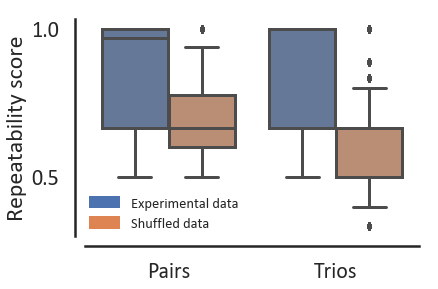

In [17]:
rep_plt = rep_all_sum[['sample_kind', 'max']]
rep_plt['model'] = 'Data'

prd = pd.DataFrame()
prd['max'] = concatenate(pairs_random_dist)
prd['sample_kind'] = 'Pair'
prd['model'] = 'Fully shuffled'

trd = pd.DataFrame()
trd['max'] = concatenate(trios_random_dist)
trd['sample_kind'] = 'Trio'
trd['model'] = 'Fully shuffled'
                         
rep_plt = pd.concat([rep_plt,prd, trd])




sns.boxplot(data= rep_plt[rep_plt['model']!='Shuffled by species'], 
            x = 'sample_kind',
            y = 'max', hue = 'model',  
            palette = 'deep', saturation = 0.5,
           whis = 1)
import matplotlib.patches as mpatches
p1 = mpatches.Patch(color=sns.color_palette('deep')[0], label='Experimental data', edgecolor='b')
p2 = mpatches.Patch(color=sns.color_palette('deep')[1], label='Shuffled data', edgecolor='b')
legend(handles= [p1, p2], frameon = False, fontsize = 'x-large', loc = (0, 0))
yticks([0.5, 1])
sns.despine()

ylabel('Repeatability score')
xlabel('')
xticks([0, 1],['Pairs', 'Trios'])

sns.despine(offset=10)

## Predictions

We used the formerly established methods for predicting the composition of trios from the composition of pairs that was developed by Abreu et al. In this approach the fraction of a species when grown in a multispecies community is predicted as the weighted geometric mean of the fraction of the species in all pairwise cultures

When prediciting by monocultures, we predict the fraction of a species in a community as its relatvie productivity in monoculuture:
$$f_{ic_{t}} = \frac{Y_{i_{t}}}{\sum{Y_{j_{t}}}}$$
where $f_{ic_{t}}$ is the fraction of species i at time t within community c;
$Y_{i_{t}}$ is the OD od species i at time t when grown in monoculutre; and $\sum{Y_{j_{t}}}$ is the sum OD of all of the species when grown in monoculutre

When predicting by pairs, we predict the fraction of a species in a multispecies community as its weighted geometric mean in pairs:
$$f_{1_{t}} = (f^{w_2}_{12}f^{w_3}_{13})^{\frac{1}{w_2w_3}} $$

where 
$$w_{2} = \sqrt{f_{21}f_{23}}, w_{3} = \sqrt{f_{31}f_{32}}$$

These fractions are then normalized by $f^*_{1} = \frac{f_1}{f_1+f_2+f_3}$

In [18]:
prediction_table = pd.DataFrame(columns=['sample', 'Generation', 'observation', 'pair_prediction', 'mono_prediction'])

prediction_table['sample'] = tile(trios, len(gens[gens!=0]))
prediction_table['Generation'] = repeat(gens[gens!=0], len(trios))

# actual observations:
prediction_table['observation'] = prediction_table.apply(lambda x: bysamp[x['sample'].split('_')][bysamp['sample']==x['sample']][bysamp['Generation']==x['Generation']].values.squeeze(), axis = 1)

# predicted by pairs:
prediction_table['pair_prediction'] = prediction_table.apply(lambda x: cef.pair_trio_prediction(x['sample'], bysamp[bysamp['Generation']==x['Generation']]).values.squeeze(), axis = 1)
# predicted by monoculture:
prediction_table['mono_prediction'] = prediction_table.apply(lambda x:[OD['OD'][OD['sample']==sp][OD['Generation']==x['Generation']].mean() for sp in x['sample'].split('_')]/sum([OD['OD'][OD['sample']==sp][OD['Generation']==x['Generation']].mean() for sp in x['sample'].split('_')]).mean(), axis = 1)
#predicted by pairs at generation 70:

prediction_table['pred_by70'] = prediction_table.apply(lambda x: cef.pair_trio_prediction(x['sample'], bysamp[bysamp['Generation']==7*10.5]).values.squeeze(), axis = 1)

# removing NaN
prediction_table = prediction_table[prediction_table['pair_prediction'].apply(lambda x:x[0] >-1)]
prediction_table = prediction_table[prediction_table['observation'].apply(lambda x:len(x)>0)]

we measure the accuracy of the error as the Euclidean distance between the observation and the prediction normalized to the maximum distance between two communities with the same n species - $\sqrt(n)$

In [19]:
prediction_table['By_pairs'] = prediction_table.apply(lambda x: euclidean(x['pair_prediction'], x['observation'])/sqrt(3), axis = 1)
prediction_table['By_pairs70'] = prediction_table.apply(lambda x: euclidean(x['pred_by70'], x['observation'])/sqrt(3), axis = 1)
prediction_table['By_mono'] = prediction_table.apply(lambda x: euclidean(x['mono_prediction'], x['observation'])/sqrt(3), axis = 1)

#the uniformed guess is that the species are at equal abundances
prediction_table['Uninformed'] = prediction_table.apply(lambda x: euclidean([1/3, 1/3, 1/3], x['observation'])/sqrt(3), axis = 1)


prediction_sum = prediction_table[["Generation", 'By_pairs', 'By_mono', 'Uninformed','By_pairs70']].groupby('Generation')

# prediction_sum.mean().to_excel('proccesed_data/pred_sum_mean.xlsx')
# prediction_sum.sem().to_excel('proccesed_data/pred_sum_sem.xlsx')

(0, 400)

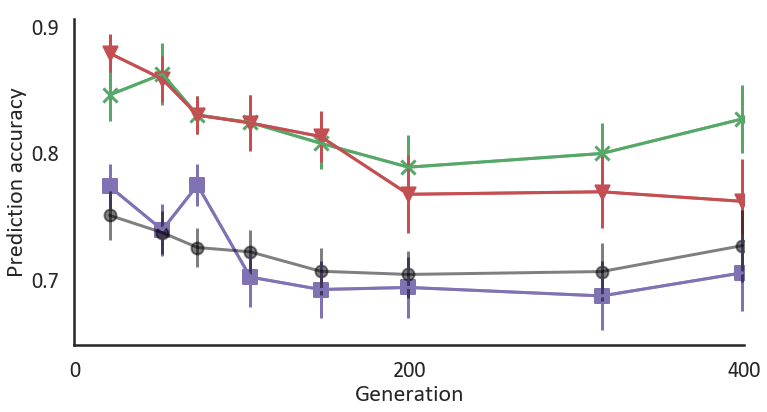

In [20]:
fig, ax = subplots(1, 1, figsize = (12, 6))

prediction_sum_mean = prediction_sum.mean().reset_index()
prediction_sum_sem = prediction_sum.sem().reset_index()

marks = ['x', 'v', 's', 'o']
for i, pr in enumerate(['By_pairs','By_pairs70', 'By_mono']):
    ax.plot(prediction_sum_mean['Generation'], 1-prediction_sum_mean[pr],
             color = sns.color_palette('deep')[i+2], alpha = 0.7)
    ax.scatter(prediction_sum_mean['Generation'], 1-prediction_sum_mean[pr],
                color = sns.color_palette('deep')[i+2], marker = marks[i], s = 200)
    ax.errorbar(prediction_sum_mean['Generation'],
            1- prediction_sum_mean[pr], prediction_sum_sem[pr],color = sns.color_palette('deep')[i+2])
    

ax.scatter(prediction_sum_mean['Generation'], 1-prediction_sum_mean['Uninformed'],
            color = 'k', marker = 'o', alpha = 0.5)
ax.errorbar(prediction_sum_mean['Generation'],
        1- prediction_sum_mean['Uninformed'], prediction_sum_sem['Uninformed'],color = 'k', alpha = 0.5)


ax.set_ylabel('Prediction accuracy')
ax.set_xlabel('Generation')
ax.set_yticks([0.7, 0.8, 0.9])
ax.set_yticklabels([0.7, 0.8, 0.9])
ax.set_xticks([0, 200, 400])
ax.spines['top'].set_visible(False) 
ax.spines['right'].set_visible(False) 
ax.set_xlim(0, 400)

We use the factors by which species increased their abundance during coevolution in pairs (between generations ~70 and ~400) to predict which species would increase by the largest factor in trios. The maximally increasing member in a given community was assigned to be the one that was the maximally increasing member in the most replicates of that community. If the same species was the maximally increasing member in both pairs it was a member of, then this species was predicted to be the maximally increasing member of the trio. If in every pair a different species was the maximally increasing member, then we predicted that the maximally increasing member of the trio would be the one with the highest mean increase.

In [21]:
trs_ql = rep_all_sum[rep_all_sum['sample_kind']=='Trio']
trs_ql['prediction'] = trs_ql['sample'].apply(lambda x:cef.predict_max_inc(x, rep_all_sum, rep_all.groupby('sample')['fold_increase'].apply(mean).reset_index()))
trs_ql = trs_ql.dropna()
trs_ql = trs_ql[trs_ql['size']>2].dropna()
trs_ql['prediction'] = trs_ql.apply(lambda x: where(array(x['sample'].split('_'))==x['prediction'])[0][0], axis = 1)
suc = ((trs_ql['prediction'] == trs_ql['most_freq']).sum() )
n = len(trs_ql)
scipy.stats.binom_test(suc, n, p = 1/3 ,alternative='greater')
print('Prediction accuracy = ', round((trs_ql['prediction'] == trs_ql['most_freq']).sum()/ len(trs_ql), 2),
      '\n Sample size = ' ,len(trs_ql),
     '\n P-value = ', scipy.stats.binom_test(suc, n, p = 1/3 ,alternative='greater'))

Pch_Pf_Ab :no hierarchy
Pch_Sm_IN65 :no hierarchy
Prediction accuracy =  0.82 
 Sample size =  22 
 P-value =  4.1531102398665305e-06


C:\Users\friedman-lab\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


We use strains growth abilities (carrying capacity and growth rate) to predict their fractions in pairs

In [22]:
def max_min(l):
    return max(l) / min(l)

grs = pd.read_excel('proccesed_data/growth_rates.xlsx') #table with strains growth rates, to see how these were obtained go to growth_rates.ipynb

end = cf_psu['transfer']==38
ee = cf_psu['transfer']==7

pair_table = by_ide[by_ide['sample_kind']=='Pair'].copy()
pair_table['fractions_t38'] = pair_table.apply(lambda x:cef.get_species_fraction(cf_psu, x['sample'].split('_'), x['ident'], 38), axis = 1)
pair_table['fractions_t7'] = pair_table.apply(lambda x:cef.get_species_fraction(cf_psu, x['sample'].split('_'), x['ident'], 7), axis = 1)
pair_table= pair_table[~pair_table['fractions_t38'].apply(lambda x:size(x) ==0)][~pair_table['fractions_t7'].apply(lambda x:size(x) ==0)]
pair_table['frac1_7'] = pair_table['fractions_t7'].apply(lambda x:x[0][0])
pair_table['frac1_38'] = pair_table.apply(lambda x:x['fractions_t38'][0][0], axis = 1)
pair_table['sp1'] = pair_table.apply(lambda x:x['sample'].split('_')[0], axis = 1)
pair_table['sp2'] = pair_table.apply(lambda x:x['sample'].split('_')[1], axis = 1)

pair_sum = pair_table[~pair_table['sample'].isin(['Pci_H77', 'Pv_H77'])].groupby('sample').mean().reset_index()
pair_sum['anc_growth_rate'] = pair_sum['sample'].apply(lambda x: [grs['effective_growth_rate'][grs['species']==sp][grs['ev/anc'] == 'Ancestor'].squeeze() for sp in x.split('_')])
pair_sum['evo_growth_rate'] = pair_sum['sample'].apply(lambda x: [grs['effective_growth_rate'][grs['species']==sp][grs['ev/anc'] == 'Evolved'].squeeze() for sp in x.split('_')])
pair_sum['k70'] = pair_sum['sample'].apply(lambda x: [OD['OD'][OD['transfer']==7][OD['sample']==sp].mean() for sp in x.split('_')])
pair_sum['k400'] = pair_sum['sample'].apply(lambda x: [OD['OD'][OD['transfer']==38][OD['sample']==sp].mean()for sp in x.split('_')])
pair_sum['evo_gr/anc_gr'] = pair_sum.apply(lambda x: divide(x['evo_growth_rate'],x['anc_growth_rate']), axis = 1)
pair_sum['k400/k70'] = pair_sum.apply(lambda x: divide(x['k400'],x['k70']), axis = 1)

Text(0.5,-0.15,'Predictor')

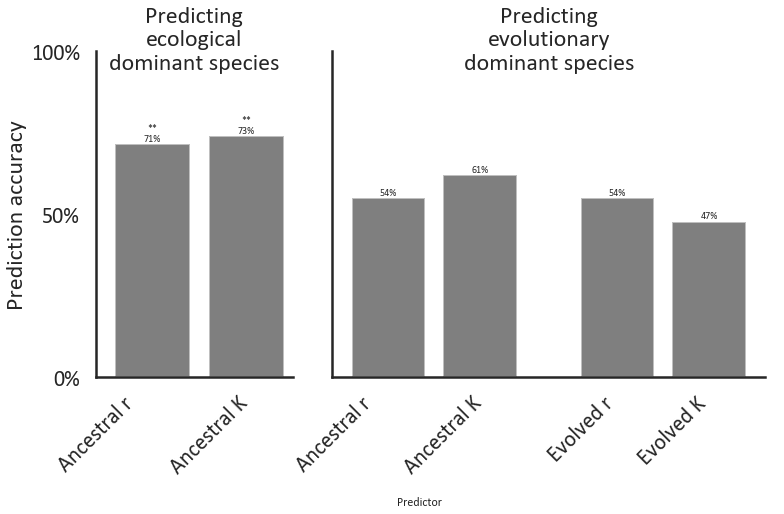

In [23]:

fig = plt.figure(constrained_layout=True, figsize=(12, 6))
gs = gridspec.GridSpec(1, 3)

gr_a, cc_a = pair_sum.apply(lambda x: x['frac1_7'] if argmax(x['anc_growth_rate'])==0 else 1-x['frac1_7'], axis = 1), pair_sum.apply(lambda x: x['frac1_7'] if argmax(x['k70'])==0 else 1-x['frac1_7'], axis = 1)
gr_b, cc_b = pair_sum.apply(lambda x: x['frac1_38'] if argmax(x['anc_growth_rate'])==0 else 1-x['frac1_38'], axis = 1), pair_sum.apply(lambda x: x['frac1_38'] if argmax(x['k70'])==0 else 1-x['frac1_38'], axis = 1)
gr_c, cc_c = pair_sum.apply(lambda x: x['frac1_38'] if argmax(x['evo_growth_rate'])==0 else 1-x['frac1_38'], axis = 1), pair_sum.apply(lambda x: x['frac1_38'] if argmax(x['k400'])==0 else 1-x['frac1_38'], axis = 1)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1:3])

ax1.bar([0, 1],
    [sum(gr_a > 0.5)/sum(gr_a>=0)*100, sum(cc_a > 0.5)/sum(cc_a>=0)*100], 
    color = 'k', alpha = 0.5)
ax1.text(0, sum(gr_a > 0.5)/sum(gr_a>=0)*100+1, '**\n'+str(int(sum(gr_a > 0.5)/sum(gr_a>=0)*100)) + '%',horizontalalignment='center')
ax1.text(1, sum(cc_a > 0.5)/sum(cc_a>=0)*100+1, '**\n'+str(int(sum(cc_a > 0.5)/sum(cc_a>=0)*100)) + '%',horizontalalignment='center')

ax2.bar([0, 1, 2.5, 3.5],
    [sum(gr_b > 0.5)/sum(gr_b>=0)*100, sum(cc_b > 0.5)/sum(cc_b>=0)*100,
     sum(gr_c > 0.5)/sum(gr_c>=0)*100, sum(cc_c > 0.5)/sum(cc_c>=0)*100], 
    color = 'k', alpha = 0.5)
ax1.set_xticklabels(['Ancestral r', 'Ancestral K'], rotation = 45);
ax1.set_xticks([-0.6,0.6]) 
ax2.set_xticks([-.6, .6, 2.1, 3.1]) 
ax2.set_xticklabels(['Ancestral r', 'Ancestral K', 
                    'Evolved r', 'Evolved K'], rotation = 45);
ax1.set_yticks([0, 50 ,100]);
ax1.set_yticklabels(['0%', "50%", '100%']);
ax1.set_ylabel('Prediction accuracy')
ax1.set_ylim(0, 100)
ax2.set_yticks([]);
ax2.set_ylim(0, 100)

ax2.text(0, sum(gr_b > 0.5)/sum(gr_b>=0)*100+1, str(int(sum(gr_b> 0.5)/sum(gr_b>=0)*100)) + '%',horizontalalignment='center')
ax2.text(1, sum(cc_b > 0.5)/sum(cc_a>=0)*100+1, str(int(sum(cc_b > 0.5)/sum(cc_b>=0)*100)) + '%',horizontalalignment='center')

ax2.text(2.5, sum(gr_c > 0.5)/sum(gr_c>=0)*100+1, str(int(sum(gr_c> 0.5)/sum(gr_c>=0)*100)) + '%',horizontalalignment='center')
ax2.text(3.5, sum(cc_c > 0.5)/sum(cc_c>=0)*100+1, str(int(sum(cc_c > 0.5)/sum(cc_c>=0)*100)) + '%',horizontalalignment='center')

ax1.set_title('Predicting\necological\ndominant species', pad = -18)
ax2.set_title('Predicting\nevolutionary\ndominant species', pad = -18)
sns.despine()

suptitle('Predictor', y = -.15)

C:\Users\friedman-lab\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
C:\Users\friedman-lab\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


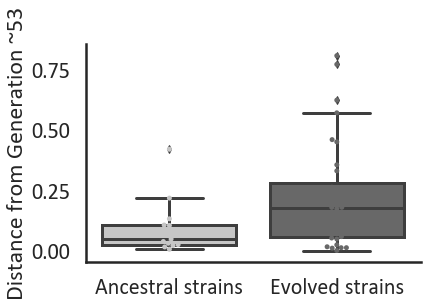

In [24]:
exp19_counts = pd.read_excel('raw_data/counts_exp19.xlsx')
exp19_counts = exp19_counts.fillna(0)

exp19_counts['total'] = exp19_counts[species].apply(sum, axis = 1)
exp19_counts = exp19_counts[exp19_counts['total']>5].reset_index(drop = True)
exp19_counts[species] = exp19_counts[species].apply(lambda x:x/exp19_counts['total'])

exp19_counts = exp19_counts[exp19_counts['transfer']==5].reset_index(drop = True)

gr19  = exp19_counts.groupby(['sample', 'exp14_ident', 'treatment']).mean().reset_index().groupby(['sample', 'treatment']).mean().reset_index()
sum_19 = gr19[['sample', 'treatment']]
sum_19['ecological'] = gr19.apply(lambda x: euclidean(x[x['sample'].split('_')].values,
                                   bysamp[x['sample'].split('_')][bysamp['sample']==x['sample']][bysamp['transfer']==5].values.squeeze()), axis = 1)
sum_19['evolutionary'] = gr19.apply(lambda x: euclidean(x[x['sample'].split('_')].values,
                                   bysamp[x['sample'].split('_')][bysamp['sample']==x['sample']][bysamp['transfer']==38].values.squeeze()), axis = 1)


sns.swarmplot(data = sum_19, x = 'treatment', y = 'ecological', palette = 'Greys')
sns.boxplot(data = sum_19, x = 'treatment', y = 'ecological', palette = 'Greys')
ylabel('Distance from Generation ~53')
xlabel('')
xticks([0, 1], ['Ancestral strains', 'Evolved strains'])
sns.despine()

In [25]:
doc_rep = pd.DataFrame(doc_rep).rename({'sample_kind':'Initial number of replicates'}, axis =1)
# doc_rep['final number of replicates'] = counts[counts['transfer']==38].groupby('sample')['sample_kind'].count()
doc_rep['Contaminated replicates'] = contaminated_bysamp
doc_rep['Did not coexsist for ~70 generations'] = lc[lc['last_coex']<7].groupby('sample')['sample_kind'].count()
doc_rep = doc_rep.fillna(0)
doc_rep.head()

,Initial number of replicates,Contaminated replicates,Did not coexsist for ~70 generations
sample,,,
Ab,6,0.0,0.0
Ab_Fj,6,1.0,0.0
Ab_H79,3,0.0,0.0
Ab_IN72,9,0.0,0.0
Ea,6,0.0,0.0
